# Introduction to DataFrames
**[Bogumił Kamiński](http://bogumilkaminski.pl/about/), May 26, 2020**

In [1]:
using DataFrames

## Load and save DataFrames
We do not cover all features of the packages. Please refer to their documentation to learn them.

Here we'll load `CSV` and `CSVFiles` to read and write CSV files and `Feather`, `JLSO`, and serialization, which allow us to work with a binary format and `JSONTables` for JSON interaction.

In [2]:
using CSV
using CSVFiles
using Serialization
using JLSO
using Feather
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots # for charts

Let's create a simple `DataFrame` for testing purposes,

In [3]:
x = DataFrame(A=[true, false, true], B=[1, 2, missing],
              C=[missing, "b", "c"], D=['a', missing, 'c'])


,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


and use `eltypes` to look at the columnwise types.

In [4]:
eltype.(eachcol(x))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### CSV.jl

Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [5]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [6]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back (`use_mmap=false` disables memory mapping so that on Windows the file can be deleted in the same session, on other OSs it is not needed).

In [7]:
y = CSV.read("x1.csv", use_mmap=false)

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


Note that when loading in a `DataFrame` from a `CSV` the column type for column `:D` has changed!

In [8]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### CSVFiles.jl

Now we will use `CSVFiles` to achieve the same. First we save the file. Notice that we override default `nastring` that is `"NA"` because we have missings in non-numeric columns.

In [9]:
x |> save("x2.csv", nastring="")

and peek the saved file:

In [10]:
print(read("x2.csv", String))

"A","B","C","D"
true,1,,a
false,2,"b",
true,,"c",c


We can load it back using `load`:

In [11]:
y = load("x2.csv") |> DataFrame

,A,B,C,D
,String,Int64?,String,String
1,true,1,,a
2,false,2,b,
3,true,missing,c,c


Let us check element types again:

In [12]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 String
 Union{Missing, Int64}
 String
 String

Observe that in columns `:C` and `:D` missings were read back as empty strings. Also `Bool` got converted to `String`.

### Serialization, JDF.jl, and JLSO.jl

#### Serialization

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process will not work if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [13]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognise the content as DataFrames.jl

In [14]:
y = open(deserialize, "x.bin")

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


In [15]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

#### JDF.jl

[JDF.jl](https://github.com/xiaodaigh/JDF) is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.

In [16]:
savejdf("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [17]:
x_loaded = loadjdf("x.jdf")

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


You can see that they are the same

In [18]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files

In [19]:
# set up a JDFFile which is a on disk representation of `x` backed by JDF.jl
x_ondisk = jdf"x.jdf"

JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [20]:
names(x_ondisk)

4-element Array{String,1}:
 "A"
 "B"
 "C"
 "D"

The below is an example of how to load only columns `:A` and `:D` 

In [21]:
xd = sloadjdf(x_ondisk; cols = ["A", "D"])

,A,D
,Bool,Char?
1,1,'a'
2,0,missing
3,1,'c'


##### JDF.jl vs others

JDF.jl is specialized to DataFrames and only supports a restricted list of columns, so it can not save DataFrames with arbitrary column types. However, this also means that JDF.jl has specialised algorithms to serailize the type it supports to optimize speed, minimize disk usage, and reduce the chance of errors

The list support columns for JDF include

```julia
WeakRefStrings.StringVector
Vector{T}, Vector{Union{Mising, T}}, Vector{Union{Nothing, T}}
CategoricalArrays.CategoricalVetors{T}
```

where `T` can be `String`, `Bool`, `Symbol`, `Char`, `TimeZones.ZonedDateTime` (experimental) and `isbit`s types i.e. `UInt*`, `Int*`, `Float*`, and `Date*` types etc.

#### JLSO.jl

Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [22]:
JLSO.save("x.jlso", :data => x)

Now we can laod back the file to `y`

In [23]:
y = JLSO.load("x.jlso")[:data]

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


In [24]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### JSONTables.jl

Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [25]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [26]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [27]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [28]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [29]:
y1 = open(jsontable, "x1.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [30]:
eltype.(eachcol(y1))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

In [31]:
y2 = open(jsontable, "x2.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [32]:
eltype.(eachcol(y2))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Feather.jl

Finally we use Feather format that allows, in particular, for data interchange with R or Python.

In [33]:
x.D = passmissing(string).(x.D) # Feather format does not support Char type

3-element Array{Union{Missing, String},1}:
 "a"
 missing
 "c"

In [34]:
Feather.write("x.feather", x)

"x.feather"

In [35]:
y = Feather.materialize("x.feather") # Feather.read is a lazy alternative

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [36]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Basic bechmarking

Next, we'll create some files, so be careful that you don't already have these files in your working directory!

In particular, we'll time how long it takes us to write a `DataFrame` with 10^3 rows and 10^5 columns.

In [37]:
bigdf = DataFrame(rand(Bool, 10^5, 500))
bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")
println("First run")
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("CSVFiles.jl")
csvfileswrite1 = @elapsed @time bigdf |> save("bigdf2.csv")
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time savejdf("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Feather.jl")
featherwrite1 = @elapsed @time Feather.write("bigdf.feather", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("CSVFiles.jl")
csvfileswrite2 = @elapsed @time bigdf |> save("bigdf2.csv")
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time savejdf("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Feather.jl")
featherwrite2 = @elapsed @time Feather.write("bigdf.feather", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

First run
CSV.jl
  8.225849 seconds (152.06 M allocations: 2.331 GiB, 9.45% gc time)
CSVFiles.jl
 12.792522 seconds (6.18 M allocations: 373.478 MiB, 0.57% gc time)
Serialization
  1.280607 seconds (204.40 k allocations: 10.697 MiB)
JDF.jl
  0.463312 seconds (96.95 k allocations: 166.966 MiB, 4.41% gc time)
JLSO.jl
  8.829102 seconds (290.41 k allocations: 178.629 MiB, 0.15% gc time)
Feather.jl
  0.254691 seconds (499.97 k allocations: 49.573 MiB, 3.65% gc time)
JSONTables.jl arraytable
168.000230 seconds (1.15 G allocations: 222.627 GiB, 8.12% gc time)
JSONTables.jl objecttable
  1.813862 seconds (386.70 k allocations: 1.403 GiB, 2.00% gc time)
Second run
CSV.jl
  7.677150 seconds (150.14 M allocations: 2.247 GiB, 4.06% gc time)
CSVFiles.jl
  6.865196 seconds (606.56 k allocations: 105.606 MiB)
Serialization
  1.189541 seconds (5.62 k allocations: 771.223 KiB)
JDF.jl
  0.432028 seconds (20.63 k allocations: 163.216 MiB, 11.94% gc time)
JLSO.jl
  8.699682 seconds (26.40 k allocations: 

1.358529052

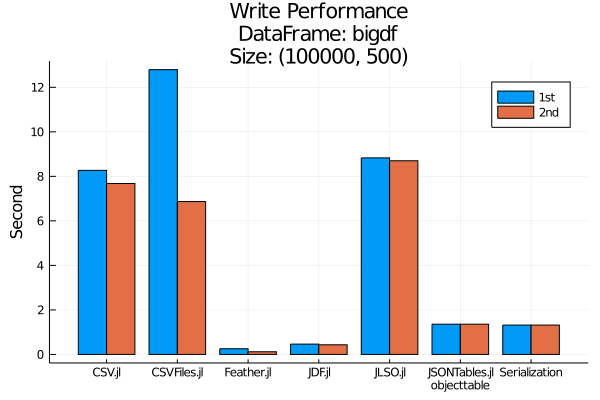

In [38]:
groupedbar(
    #repeat(["CSV.jl", "CSVFiles.jl", "Serialization", "JDF.jl", "JLSO.jl", "Feather.jl", "JSONTables.jl\narraytable", "JSONTables.jl\nobjecttable"], inner = 2),
    #[csvwrite1, csvwrite2, csvfileswrite1, csvfileswrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2, jlsowrite1, jlsowrite2, featherwrite1, featherwrite2, jsontablesawrite1, jsontablesawrite2, jsontablesowrite2, jsontablesowrite2],
    # Exclude JSONTables.jl arraytable due to timing
    repeat(["CSV.jl", "CSVFiles.jl", "Serialization", "JDF.jl", "JLSO.jl", "Feather.jl", "JSONTables.jl\nobjecttable"],
            inner = 2),
    [csvwrite1, csvwrite2, csvfileswrite1, csvfileswrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2,
     jlsowrite1, jlsowrite2, featherwrite1, featherwrite2, jsontablesowrite2, jsontablesowrite2],
    group = repeat(["1st", "2nd"], outer = 7),
    ylab = "Second",
    title = "Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [39]:
data_files = ["bigdf1.csv", "bigdf2.csv", "bigdf.bin", "bigdf.feather", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file = data_files, size = getfield.(stat.(data_files), :size))
append!(df, DataFrame(file = "bigdf.jdf", size=reduce((x,y)->x+y.size,
                                                      stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))),
                                                      init=0)))

,file,size
,String,Int64
1,bigdf1.csv,275801340
2,bigdf2.csv,275802340
3,bigdf.bin,28210089
4,bigdf.feather,9797928
5,bigdf1.json,615198949
6,bigdf2.json,275803341
7,bigdf.jdf,26018250


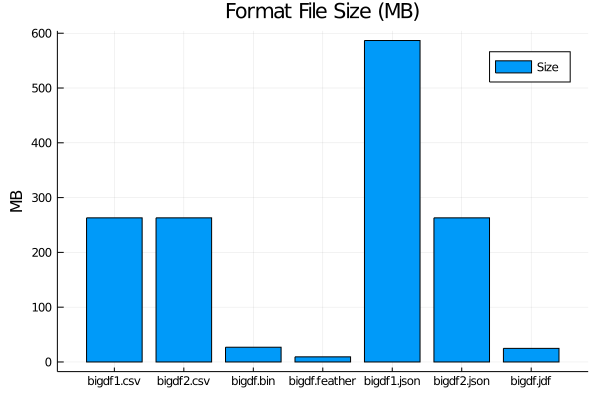

In [40]:
@df df plot(:file, :size/1024^2, seriestype=:bar, title = "Format File Size (MB)", label="Size", ylab="MB")

In [41]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv")
println("CSVFiles.jl")
println("  disabled due to time-out")
# @time load("bigdf2.csv") |> DataFrame
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time loadjdf("bigdf.jdf")
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Feather.jl")
featherread1 = @elapsed @time Feather.materialize("bigdf.feather")
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv")
println("CSVFiles.jl")
println("  disabled due to time-out")
# @time load("bigdf2.csv") |> DataFrame
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time loadjdf("bigdf.jdf")
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Feather.jl")
featherread2 = @elapsed @time Feather.materialize("bigdf.feather")
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl
  2.785704 seconds (512.69 k allocations: 874.381 MiB, 9.03% gc time)
CSVFiles.jl
  disabled due to time-out
Serialization
  2.592653 seconds (49.66 M allocations: 810.865 MiB, 10.89% gc time)
JDF.jl
  0.807907 seconds (180.15 k allocations: 155.762 MiB, 2.65% gc time)
JLSO.jl
  2.120210 seconds (49.68 M allocations: 819.987 MiB, 4.89% gc time)
Feather.jl
  0.670653 seconds (757.55 k allocations: 135.167 MiB, 2.98% gc time)
JSONTables.jl arraytable
  3.245704 seconds (27 allocations: 586.701 MiB, 2.46% gc time)
JSONTables.jl objecttable
  1.811115 seconds (2.92 k allocations: 263.199 MiB)
Second run
  2.954778 seconds (7.45 k allocations: 848.555 MiB, 11.26% gc time)
CSVFiles.jl
  disabled due to time-out
Serialization
  2.816147 seconds (49.65 M allocations: 810.172 MiB, 18.48% gc time)
JDF.jl
  0.642740 seconds (22.20 k allocations: 148.231 MiB, 2.92% gc time)
JLSO.jl
  2.060383 seconds (49.66 M allocations: 819.368 MiB, 4.84% gc time)
Feather.jl
  0.318256 seconds (

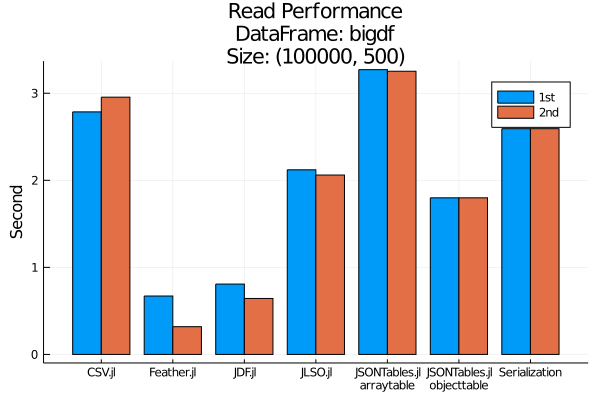

In [42]:
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Feather.jl", "JSONTables.jl\narraytable",
            "JSONTables.jl\nobjecttable"], inner = 2),
    [csvread1, csvread2, serializeread1, serializeread1, jdfread1, jdfread2, jlsoread1, jlsoread2,
     featherread1, featherread2, jsontablesaread1, jsontablesaread2, jsontablesoread2, jsontablesoread2],    
    group = repeat(["1st", "2nd"], outer = 7),
    ylab = "Second",
    title = "Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

### Using gzip compression

A common user requirement is to be able to load and save CSV that are compressed using gzip.
Below we show how this can be accomplished using CodecZlib.jl.
The same pattern is applicable to JSONTables.jl compression/decompression.

Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory

We first generate a random data frame

In [43]:
df = DataFrame(rand(1:10, 10, 1000))

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2,8,7,3,1,9,5,6,5,1,6,7
2,7,5,2,1,9,4,8,8,7,8,8,4
3,10,9,1,8,3,7,10,1,7,2,9,6
4,3,1,10,3,8,3,7,7,4,6,9,5
5,6,1,5,3,2,4,7,5,7,9,9,10
6,8,4,10,3,2,5,5,1,3,9,7,8
7,4,6,9,5,6,1,3,8,7,4,5,8
8,6,8,2,10,6,3,3,6,4,1,5,9
9,1,9,7,9,3,8,6,5,8,8,1,5


In [44]:
# GzipCompressorStream comes from CodecZlib

open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [45]:
df2 = open("df_compress_test.csv.gz") do io
    stream = GzipDecompressorStream(io)
    res = CSV.read(stream)
    close(stream)
    res
end

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2,8,7,3,1,9,5,6,5,1,6,7
2,7,5,2,1,9,4,8,8,7,8,8,4
3,10,9,1,8,3,7,10,1,7,2,9,6
4,3,1,10,3,8,3,7,7,4,6,9,5
5,6,1,5,3,2,4,7,5,7,9,9,10
6,8,4,10,3,2,5,5,1,3,9,7,8
7,4,6,9,5,6,1,3,8,7,4,5,8
8,6,8,2,10,6,3,3,6,4,1,5,9
9,1,9,7,9,3,8,6,5,8,8,1,5


In [46]:
df == df2

true

### Using zip files

Sometimes you may have files compressed inside a zip file.

In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.

Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [47]:
df1 = DataFrame(rand(1:10, 3, 4))

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,8,4,3,9
2,3,9,7,8
3,3,4,5,8


In [48]:
df2 = DataFrame(rand(1:10, 3, 4))

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,3,9,1,2
2,6,1,9,2
3,2,1,3,9


And we show yet another way to write a `DataFrame` into a CSV file

In [49]:
# write a CSV file into the zip file
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the CSV we have written:

In [50]:
z = ZipFile.Reader("x.zip");

In [51]:
# find the index index of file called x1.csv
index_xcsv = findfirst(x->x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(z.files[index_xcsv])

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,8,4,3,9
2,3,9,7,8
3,3,4,5,8


In [52]:
df1_2 == df1

true

In [53]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x->x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(z.files[index_xcsv])

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,3,9,1,2
2,6,1,9,2
3,2,1,3,9


In [54]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (it is at its end). Therefore to read it again you need to close `z` and open it again.

Also do not forget to close the zip file once done.

In [55]:
close(z)

Finally, let's clean up. Do not run the next cell unless you are sure that it will not erase your important files.

In [56]:
foreach(rm, ["x1.csv", "x2.csv", "x.bin", "x.jlso", "x.feather", "x1.json", "x2.json",
             "bigdf1.csv", "bigdf2.csv", "bigdf.bin", "bigdf.jlso", "bigdf.feather", "bigdf1.json", "bigdf2.json", 
             "df_compress_test.csv.gz", "x.zip"])

In [57]:
rm("bigdf.jdf", recursive=true)
rm("x.jdf", recursive=true)